# Notes on "the value function polytope in reinforcement learning"

https://arxiv.org/abs/1901.11524


In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
from arsenal.viz.util import contour_plot
from arsenal.maths import random_dist, anneal
from itertools import product
from rl.mdp import random_MDP, DiscountedMDP
from rl.util import Halfspaces


def plot_cons(P, R, gamma, xscale, yscale):
    S, A = R.shape
    assert S == 2

    C = []; b = []
    for s in range(S):
        for a in range(A):
            c = np.zeros(2)
            C.append(c)
            b.append(R[s,a])
            for sp in range(S):
                c[sp] = (s == sp) - gamma*P[s,a,sp]

    C = np.array(C); b = np.array(b)
    Halfspaces(-C, -b).viz(xscale[:-1], yscale[:-1])


def all_det_policies(S, A):
    return np.eye(A)[np.array(list(product(range(A), repeat=S)))]


def visualize(M):
    pl.figure(figsize=(10,10))

    # Use Peirre-Luc's sampling strategy to approximate the polytope
    n_policies = 10000
    random_policies = [random_dist(M.S, M.A) for _ in range(n_policies)]
    det_policies = all_det_policies(M.S, M.A)

    vfs = np.array([M.mrp(pi).V() for pi in random_policies])
    dvfs = np.array([M.mrp(pi).V() for pi in det_policies])

    r = M.r

    v = dvfs
    offset = v[:,0].ptp() * .2
    xs = [min(v[:,0])-offset, max(v[:,0])+offset, 100]
    ys = [min(v[:,1])-offset, max(v[:,1])+offset, 100]
    plot_cons(M.P, r, M.gamma, xs, ys)

    contour_plot(
        lambda v: (1-M.gamma) * M.s0 @ v,
        xs,
        ys,
    )

    sol = M.solve()
    V = sol['V']

    if 1:
        pl.scatter(vfs[:,0], vfs[:,1], s=1, c='k', alpha=0.1)
        pl.scatter(dvfs[:,0], dvfs[:,1], s=20, c='r', zorder=1000)
        pl.title('Value function polytope')

    pl.scatter(*V, c='r', s=200, marker='*')
    pl.xlabel('$V_{\pi}(s_0)$'); pl.ylabel('$V_{\pi}(s_1)$')

    if 0:
        # interpolate between two random policies
        a = random_dist(M.S, M.A)
        b = random_dist(M.S, M.A)
        ts = np.linspace(0, 1, 100)
        pl.plot(*np.array([M.V((1-t)*a + t*b) for t in ts]).T, c='orange', lw=2)

    # TODO: other interesting things -- trajectories of different algorithms.
    # one-step-deviation-based search will walk a bunch of corners --
    # snake-in-the-box can make it take exp time.  This is probably related to
    # the example used to trick simplex.

    pl.tight_layout()
    pl.show()

In [13]:
examples = {
    # In Section 3, Figure 2: (a)
    0: (2, 0.9,
        [0.06, 0.38, -0.13, 0.64],
        [[0.01, 0.99], [0.92, 0.08], [0.08, 0.92], [0.70, 0.30]]),

    # (b)
    1: (2, 0.9,
        [0.88, -0.02, -0.98, 0.42],
        [[0.96, 0.04], [0.19, 0.81], [0.43, 0.57], [0.72, 0.28]]),

    # (c)
    2: (3, 0.9,
        [-0.93, -0.49, 0.63, 0.78, 0.14, 0.41],
        [[0.52, 0.48], [0.5, 0.5], [0.99, 0.01], [0.85, 0.15], [0.11, 0.89], [0.1, 0.9]]),

    # (d)
    3: (2, 0.9,
        [-0.45, -0.1, 0.5, 0.5],
        [[0.7, 0.3], [0.99, 0.01], [0.2, 0.8], [0.99, 0.01]]),

    # In Section 3, Figure 3, 4, 5, 6: (left)
    4: (3, 0.8,
        [-0.1, -1., 0.1, 0.4, 1.5, 0.1],
        [[0.9, 0.1], [0.2, 0.8], [0.7, 0.3], [0.05, 0.95], [0.25, 0.75], [0.3, 0.7]]),

    # (right)
    5: (2, 0.9,
        [-0.45, -0.1, 0.5, 0.5],
        [[0.7, 0.3], [0.99, 0.01], [0.2, 0.8], [0.99, 0.01]]),

    # In Section 5
    6: (2, 0.9,
        [-0.45, -0.1, 0.5, 0.5],
        [[0.7, 0.3], [0.99, 0.01], [0.2, 0.8], [0.99, 0.01]]),
}


def load_example(t):
    S = 2
    [A, gamma, R, P] = examples[t]

    # the MDPs in the paper are encoded in an annoying format - like they don't
    # have ndarrays.
    p = np.zeros((2,A,2))
    r = np.zeros((2,A,2))
    for i in range(S):
        for j in range(A):
            for k in range(S):
                # P(sk | si, aj ) = Pˆ[i × |A| + j][k]
                p[i,j,k] = P[i * A + j][k]
                # r(si, aj) = ˆr[i × |A| + j]
                r[i,j,k] = R[i * A + j]

    return DiscountedMDP(np.ones(S)/S, p, r, gamma)


100.0% (10000/10000) [================================================] 00:00:00


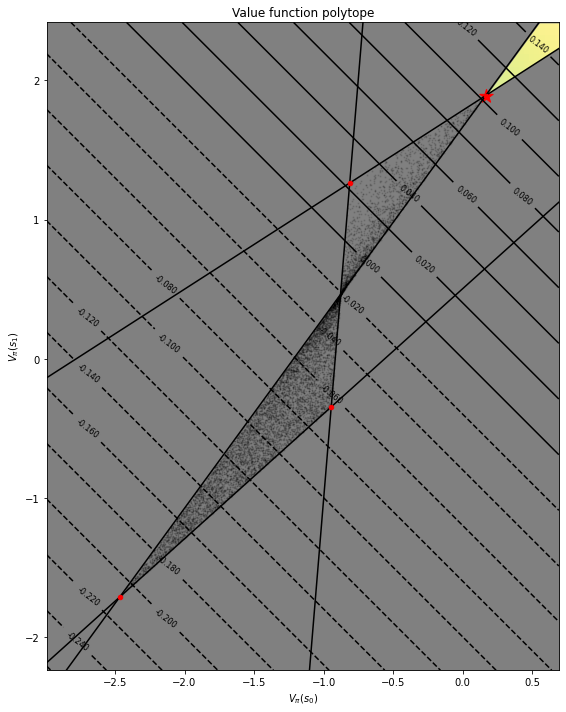

In [17]:
#M = random_MDP(S = 2, A = 2, b = None, r = None, gamma = 0.9)
visualize(load_example(3))